In [122]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

# -*- coding: utf-8 -*-
"""
Spyder Editor

This is a temporary script file.
"""
#%%

import os
import numpy as np
import pandas as pd 
import random as rn
import matplotlib.pyplot as plt; 
 
# Importing sklearn libraries
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
 
# Importing hypopt library for grid search
#from hypopt import GridSearch
 
# Importing Keras libraries
from keras.utils import np_utils
from keras import regularizers
from keras.models import model_from_json
from keras.models import Sequential
from keras.applications import VGG16
from keras.applications import imagenet_utils
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, GlobalAveragePooling2D
from keras.models import Model
import urllib
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from keras import backend as K

#for multiple outs from single cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

'\nSpyder Editor\n\nThis is a temporary script file.\n'

In [123]:
# with open('./SavedModels/modelVgg.json', 'r') as f:
#       model = model_from_json(f.read())
        
model = VGG16(weights='imagenet', include_top=False,input_shape=(224, 224, 3))
model.summary()

#modelVgg_json = model.to_json()

# with open("./SavedModels/modelVgg.json", "w") as json_file:
#     json_file.write(modelVgg_json)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [124]:
train =[os.path.join("./MobileImages/training/",train) if os.path.isfile(os.path.join("./MobileImages/training/",train)) == True else None for train in os.listdir("./MobileImages/training/")]
val  =[os.path.join("./MobileImages/validation/",validation) if os.path.isfile(os.path.join("./MobileImages/validation/",validation)) == True else None for validation in os.listdir("./MobileImages/validation/")]
test =[os.path.join("./MobileImages/test/",test) if os.path.isfile(os.path.join("./MobileImages/test/",test)) == True else None for test in os.listdir("./MobileImages/test/")]

#Rename Files in Each Folder if necessary & sync to single folder trainData
#find minor/ -type f -exec  sh -c 'mv {} $(dirname {})/$(basename $(dirname {}))_$(basename {})' \;
#rsync -a moderate/ trainData/
print(train[:1],'\n',val[:1],'\n',test[:1])

['./MobileImages/training/Damage_539.jpg'] 
 ['./MobileImages/validation/NoDamage_52.jpg'] 
 ['./MobileImages/test/Damage_377.jpg']


In [125]:
len(test)

52

In [126]:
train_y = [str(img.split("/")[-1].split("_")[0]) for img in train]
val_y = [str(img.split("/")[-1].split("_")[0]) for img in val]
test_y = [str(img.split("/")[-1].split("_")[0]) for img in test]
num_classes = 2

classes = {'NoDamage': 0, 'Damage': 1}

train_y = [x if x not in classes else classes[x] for x in train_y]
val_y = [x if x not in classes else classes[x] for x in val_y]
test_y = [x if x not in classes else classes[x] for x in test_y]

# Convert class labels in one hot encoded vector
y_train = np_utils.to_categorical(train_y, num_classes)
y_val = np_utils.to_categorical(val_y, num_classes)
y_test = np_utils.to_categorical(test_y, num_classes)

print("Train data available in 2 classes")
print([train_y.count(i) for i in range(0,2)])

print("Validation data available in 2 classes")
print([val_y.count(i) for i in range(0,2)])

print("Test data available in 2 classes")
print([test_y.count(i) for i in range(0,2)])

Train data available in 2 classes
[221, 197]
Validation data available in 2 classes
[27, 23]
Test data available in 2 classes
[27, 25]


In [127]:
def create_features(dataset, pre_model):
 
    x_scratch = []
 
    # loop over the images
    for imagePath in dataset:
        if not os.path.isfile(os.path.join(imagePath)):
            print(imagePath)
            continue
 
        # load the input image and image is resized to 224x224 pixels
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)
 
        # preprocess the image by (1) expanding the dimensions and
        # (2) subtracting the mean RGB pixel intensity from the
        # ImageNet dataset
        image = np.expand_dims(image, axis=0)
        image = imagenet_utils.preprocess_input(image)
 
        # add the image to the batch
        x_scratch.append(image)
 
    x = np.vstack(x_scratch)
    features = pre_model.predict(x, batch_size=50)
    features_flatten = features.reshape((features.shape[0], 7 * 7 * 512))
    return x, features, features_flatten

In [128]:
train_x, train_features, train_features_flatten = create_features(train, model)
val_x, val_features, val_features_flatten = create_features(val, model)
test_x, test_features, test_features_flatten = create_features(test, model)
 
print(train_x.shape, train_features.shape, train_features_flatten.shape)
print(val_x.shape, val_features.shape, val_features_flatten.shape)
print(test_x.shape, test_features.shape, test_features_flatten.shape)

(418, 224, 224, 3) (418, 7, 7, 512) (418, 25088)
(50, 224, 224, 3) (50, 7, 7, 512) (50, 25088)
(52, 224, 224, 3) (52, 7, 7, 512) (52, 25088)


In [129]:
# # Creating a checkpointer
checkpointer = ModelCheckpoint(filepath='./SavedModels/scratchmodel.best.hdf5',verbose=1,save_best_only=True)
 
# # Building up a Sequential model
# model_scratch = Sequential()
# model_scratch.add(Conv2D(32, (3, 3),  activation='relu',input_shape = train_x.shape[1:]))
# model_scratch.add(MaxPooling2D(pool_size=(2, 2)))

# model_scratch.add(Conv2D(64, (3, 3),  activation='relu'))
# model_scratch.add(MaxPooling2D(pool_size=(2, 2)))

# model_scratch.add(Conv2D(128, (3, 3), activation='relu'))
# model_scratch.add(MaxPooling2D(pool_size=(2, 2)))
 
# model_scratch.add(Dropout(0.01))
# model_scratch.add(Conv2D(128, (3, 3), activation='relu'))
# model_scratch.add(MaxPooling2D(pool_size=(2, 2)))
 
# model_scratch.add(Dropout(0.02))
# model_scratch.add(Conv2D(64, (3, 3), activation='relu'))
# model_scratch.add(MaxPooling2D(pool_size=(2, 2)))

# model_scratch.add(GlobalAveragePooling2D())
# model_scratch.add(Dropout(0.04))
# model_scratch.add(Dense(32, activation='relu'))
# model_scratch.add(Dense(2, activation='softmax'))
# model_scratch.summary()

In [130]:
# model_scratch.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
 
# #Fitting the model on the train data and labels.
# history = model_scratch.fit(train_x, y_train,
#           batch_size=32, epochs=50,
#           verbose=1, callbacks=[checkpointer],
#           validation_data=(val_x, y_val), shuffle=True)

In [131]:
def plot_acc_loss(history):
    fig = plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
 
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()


# plot_acc_loss(history)

In [132]:
# preds = np.argmax(model_scratch.predict(test_x), axis=1)
# print("\nAccuracy on Test Data: ", accuracy_score(test_y, preds))
# print("\nNumber of correctly identified imgaes: ",
#       accuracy_score(test_y, preds, normalize=False),"\n")
# confusion_matrix(test_y, preds, labels=range(0,3))


In [133]:
### For Reproducibly 

rand_seed = 1
os.environ['PYTHONHASHSEED'] = '0'

#random seed for NP genreator of ranodm numbers
np.random.seed(rand_seed)

#random seed generator for Python
rn.seed(rand_seed)

#random seed for tensorflow
tf.set_random_seed(rand_seed)

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [134]:
model_transfer = Sequential()

model_transfer.add(Conv2D(128, dilation_rate=2, kernel_size=(3, 3), input_shape=train_features.shape[1:], activation='relu', padding='same'))
model_transfer.add(Dropout(0.03))
model_transfer.add(Conv2D(64, dilation_rate=2, kernel_size=(3, 3), input_shape=train_features.shape[1:], activation='relu', padding='same'))


#model_transfer.add(Conv2D(64,strides=1,dilation_rate=2, kernel_size=(3, 3), activation='relu',input_shape=train_features.shape[1:]))

model_transfer.add(Dropout(0.03))
model_transfer.add(GlobalAveragePooling2D())
model_transfer.add(Dropout(0.04))
model_transfer.add(Dense(256, activation='relu'))
model_transfer.add(Dropout(0.03))
model_transfer.add(Dense(128, activation='relu'))
model_transfer.add(Dropout(0.02))
model_transfer.add(Dense(64, activation='relu'))
model_transfer.add(Dropout(0.02))
model_transfer.add(Dense(32, activation='relu'))
model_transfer.add(Dense(2, activation='softmax'))
   
model_transfer.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 7, 7, 128)         589952    
_________________________________________________________________
dropout_72 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 7, 7, 64)          73792     
_________________________________________________________________
dropout_73 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
global_average_pooling2d_16  (None, 64)                0         
_________________________________________________________________
dropout_74 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_73 (Dense)             (None, 256)               16640     
__________

In [135]:

from keras import optimizers
otm = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#otm = optimizers.Adagrad(lr=0.001)
#otm = optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, amsgrad=False)

model_transfer.compile(loss='categorical_crossentropy', optimizer="adam",
              metrics=['accuracy'])
history = model_transfer.fit(train_features, y_train, batch_size=32, epochs=200,
          validation_data=(val_features, y_val), callbacks=[checkpointer],verbose=1, shuffle=True)

model_transfer.save("./SavedModels/model.hd5")

# model_json = model_transfer.to_json()

# with open("./SavedModels/model.json", "w") as json_file:
#     json_file.write(model_json)

Train on 418 samples, validate on 50 samples
Epoch 1/200
418/418 [==============================] - 3s 6ms/step - loss: 0.6134 - acc: 0.6746 - val_loss: 0.5293 - val_acc: 0.7800

Epoch 00001: val_loss improved from inf to 0.52926, saving model to ./SavedModels/scratchmodel.best.hdf5
Epoch 2/200
418/418 [==============================] - 1s 2ms/step - loss: 0.3188 - acc: 0.8732 - val_loss: 0.5313 - val_acc: 0.8400

Epoch 00002: val_loss did not improve from 0.52926
Epoch 3/200
418/418 [==============================] - 1s 2ms/step - loss: 0.1645 - acc: 0.9378 - val_loss: 0.3881 - val_acc: 0.8400

Epoch 00003: val_loss improved from 0.52926 to 0.38809, saving model to ./SavedModels/scratchmodel.best.hdf5
Epoch 4/200
418/418 [==============================] - 1s 2ms/step - loss: 0.1084 - acc: 0.9665 - val_loss: 0.7921 - val_acc: 0.8200

Epoch 00004: val_loss did not improve from 0.38809
Epoch 5/200
418/418 [==============================] - 1s 2ms/step - loss: 0.0673 - acc: 0.9713 - val_l

418/418 [==============================] - 1s 2ms/step - loss: 0.0070 - acc: 0.9928 - val_loss: 1.1331 - val_acc: 0.8000

Epoch 00044: val_loss did not improve from 0.38809
Epoch 45/200
418/418 [==============================] - 1s 2ms/step - loss: 0.0066 - acc: 0.9952 - val_loss: 1.1455 - val_acc: 0.8000

Epoch 00045: val_loss did not improve from 0.38809
Epoch 46/200
418/418 [==============================] - 1s 2ms/step - loss: 0.0068 - acc: 0.9952 - val_loss: 1.1617 - val_acc: 0.8000

Epoch 00046: val_loss did not improve from 0.38809
Epoch 47/200
418/418 [==============================] - 1s 2ms/step - loss: 0.0068 - acc: 0.9952 - val_loss: 1.1734 - val_acc: 0.8000

Epoch 00047: val_loss did not improve from 0.38809
Epoch 48/200
418/418 [==============================] - 1s 2ms/step - loss: 0.0065 - acc: 0.9928 - val_loss: 1.1908 - val_acc: 0.8200

Epoch 00048: val_loss did not improve from 0.38809
Epoch 49/200
418/418 [==============================] - 1s 2ms/step - loss: 0.0070 

418/418 [==============================] - 1s 2ms/step - loss: 0.0086 - acc: 0.9952 - val_loss: 0.9797 - val_acc: 0.8200

Epoch 00088: val_loss did not improve from 0.27735
Epoch 89/200
418/418 [==============================] - 1s 2ms/step - loss: 0.0084 - acc: 0.9952 - val_loss: 1.1000 - val_acc: 0.8200

Epoch 00089: val_loss did not improve from 0.27735
Epoch 90/200
418/418 [==============================] - 1s 2ms/step - loss: 0.0086 - acc: 0.9952 - val_loss: 1.3632 - val_acc: 0.8200

Epoch 00090: val_loss did not improve from 0.27735
Epoch 91/200
418/418 [==============================] - 1s 2ms/step - loss: 0.0080 - acc: 0.9952 - val_loss: 1.1127 - val_acc: 0.8000

Epoch 00091: val_loss did not improve from 0.27735
Epoch 92/200
418/418 [==============================] - 1s 2ms/step - loss: 0.0097 - acc: 0.9952 - val_loss: 0.9047 - val_acc: 0.8000

Epoch 00092: val_loss did not improve from 0.27735
Epoch 93/200
418/418 [==============================] - 1s 2ms/step - loss: 0.0092 

418/418 [==============================] - 1s 2ms/step - loss: 0.0066 - acc: 0.9952 - val_loss: 1.3706 - val_acc: 0.8200

Epoch 00132: val_loss did not improve from 0.27735
Epoch 133/200
418/418 [==============================] - 1s 2ms/step - loss: 0.0067 - acc: 0.9976 - val_loss: 1.3956 - val_acc: 0.8200

Epoch 00133: val_loss did not improve from 0.27735
Epoch 134/200
418/418 [==============================] - 1s 2ms/step - loss: 0.0067 - acc: 0.9928 - val_loss: 1.4084 - val_acc: 0.8000

Epoch 00134: val_loss did not improve from 0.27735
Epoch 135/200
418/418 [==============================] - 1s 2ms/step - loss: 0.0066 - acc: 0.9952 - val_loss: 1.4191 - val_acc: 0.8000

Epoch 00135: val_loss did not improve from 0.27735
Epoch 136/200
418/418 [==============================] - 1s 2ms/step - loss: 0.0067 - acc: 0.9976 - val_loss: 1.4236 - val_acc: 0.8200

Epoch 00136: val_loss did not improve from 0.27735
Epoch 137/200
418/418 [==============================] - 1s 2ms/step - loss: 0.

418/418 [==============================] - 1s 2ms/step - loss: 0.0067 - acc: 0.9952 - val_loss: 1.4820 - val_acc: 0.8000

Epoch 00176: val_loss did not improve from 0.27735
Epoch 177/200
418/418 [==============================] - 1s 2ms/step - loss: 0.0068 - acc: 0.9952 - val_loss: 1.4912 - val_acc: 0.8000

Epoch 00177: val_loss did not improve from 0.27735
Epoch 178/200
418/418 [==============================] - 1s 2ms/step - loss: 0.0067 - acc: 0.9952 - val_loss: 1.4954 - val_acc: 0.8000

Epoch 00178: val_loss did not improve from 0.27735
Epoch 179/200
418/418 [==============================] - 1s 2ms/step - loss: 0.0067 - acc: 0.9952 - val_loss: 1.4876 - val_acc: 0.8000

Epoch 00179: val_loss did not improve from 0.27735
Epoch 180/200
418/418 [==============================] - 1s 2ms/step - loss: 0.0070 - acc: 0.9952 - val_loss: 1.4171 - val_acc: 0.8000

Epoch 00180: val_loss did not improve from 0.27735
Epoch 181/200
418/418 [==============================] - 1s 2ms/step - loss: 0.


Accuracy on Test Data:  0.9230769230769231

Number of correctly identified imgaes:  48 



Text(33.0, 0.5, 'True Label')

Text(0.5, 15.0, 'Predicted Label')

Text(0.5, 1, 'Confusion Matrix')

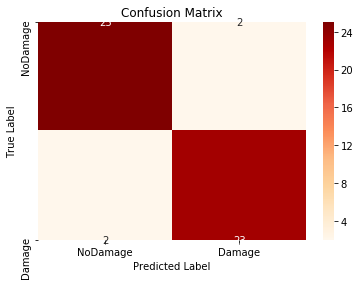

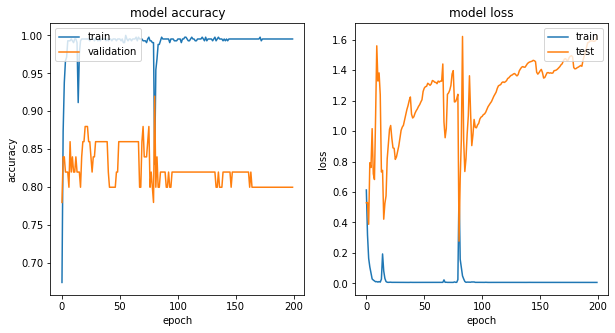

In [137]:
preds = np.argmax(model_transfer.predict(test_features), axis=1)
print("\nAccuracy on Test Data: ", accuracy_score(test_y, preds))
print("\nNumber of correctly identified imgaes: ",
      accuracy_score(test_y, preds, normalize=False),"\n")

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


heatmap_labels = ['NoDamage', 'Damage']

sns.heatmap(confusion_matrix(test_y, preds, labels=range(0,2)), annot=True, annot_kws={"size": 10}, 
            fmt='g', cmap='OrRd', xticklabels=heatmap_labels, yticklabels=heatmap_labels)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

plot_acc_loss(history)

In [52]:
def mobile_damage_estimator(image_path, model_transfer,vggModel):
    
        
    print ("Determining if damaged...")
    #urllib.urlretrieve(image_path, 'save.jpg') # or other way to upload image
    img = load_img(image_path, target_size=(224, 224)) # this is a PIL image 
    x = img_to_array(img) # this is a Numpy array with shape (3, 256, 256)
    #x = x.reshape((1,) + x.shape)/255 # this is a Numpy array with shape (1, 3, 256, 256)
    x = np.expand_dims(x, axis=0)
    
    x = imagenet_utils.preprocess_input(x)
    
    features = vggModel.predict(x, batch_size=32)
    
    pred = model_transfer.predict(features)
    
    pred_label = np.argmax(pred, axis=1)
    
    result = { "Damage Status": "NA", "Probability": 0.0}
    
    d = {0: 'NoDamage', 1: 'Damage'}
    
    for key in d.keys():
        if pred_label[0] == key:
            print ("Assessment: {} to Mobile".format(d[key]))
            result["Damage Status"] = d[key]
            result["Probability"] = str("{0:.0f}".format(int(pred[0][key]*100)))
            
    print(result)
    view_images(image_path)
    
def view_images(img):
    from IPython.display import Image, display, clear_output
    #clear_output()
    display(Image(img))

In [358]:
VggModel = VGG16(weights='imagenet', include_top=False,input_shape=(224, 224, 3))

mobile_damage_estimator('./MobileImages/1.jpg', model_transfer,VggModel)
mobile_damage_estimator('./MobileImages/2.jpg', model_transfer,VggModel)


Determining if damaged...
Assessment: Damage to Mobile
{'Damage Status': 'Damage', 'Probability': '100'}
Determining if damaged...
Assessment: Damage to Mobile
{'Damage Status': 'Damage', 'Probability': '100'}
